In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import normflows as nf
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from fab import FABModel, HamiltonianMonteCarlo, Metropolis
from fab.utils.logging import ListLogger
from fab.utils.plotting import plot_history, plot_contours, plot_marginal_pair
from fab.target_distributions.gmm import GMM
from fab.utils.prioritised_replay_buffer import SimpleBuffer
from torch.autograd import grad
from fab.utils.plotting import plot_contours, plot_marginal_pair
from experiments.make_flow import make_wrapped_normflow_realnvp
import models.ddpm
import models.mlp
import pdb
from tqdm import tqdm
from models.ddpm import GaussianDiffusion, TMLP
from models.mlp import MyMLP, SpectralNormMLP

import torch
import torchsde

from functorch import vmap

from torchdiffeq import odeint


from torch.func import jacrev

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# calculate the log expectation of the reward
def log_E_R(
    _x, _t, beta, num_mc_samples):
    h_t = beta * _t.repeat_interleave(num_mc_samples).unsqueeze(1)
    repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    h_t = beta * repeated_t
    h_t = h_t.unsqueeze(1)

    samples = repeated_x + torch.randn(repeated_x.shape).to(device) * (h_t**0.5)
    log_rewards = p1.log_prob(samples)
    log_expectation_R = torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)

    return log_expectation_R


def estimate_grad_Rt(
    x, t, beta, num_mc_samples=100):
    est_scores_n = torch.func.grad(log_E_R)(x, t, beta, num_mc_samples)
    return est_scores_n

In [65]:
def true_Rt(x, t, beta, sigma=2.0, dim=1):
    h_t = beta * t
    dist = torch.distributions.MultivariateNormal(
        torch.zeros(dim).to(device),
        torch.eye(dim).to(device)*sigma**2 + h_t,
        validate_args=False
    )
    return dist.log_prob(x)

def true_grad_Rt(x, t, beta, var_exploding=True):
    with torch.enable_grad():
        samples_energy = true_Rt(x, t, beta)
    true_scores = torch.autograd.grad(samples_energy.sum(), x, create_graph=True)[0]
    return true_scores

In [66]:
def drift(x, t):
    with torch.enable_grad():
        x.requires_grad = True
        if follow_estimate:
            f = -0.5 * beta * estimate_grad_Rt(x, t, beta, num_mc_samples=100)
            norm = torch.linalg.vector_norm(f, dim=-1)
            #print(norm.max())
            max_norm = 200
            clip_coef = torch.clamp(max_norm / (norm+1e-6), max=1)
            f = f * clip_coef.unsqueeze(-1)
        else:
            f = - 0.5 * beta * true_grad_Rt(x, t, beta)
        
    return f

In [75]:
def div_fn(u):
    """Accepts a function u:R^D -> R^D."""
    J = jacrev(u)
    return lambda x: torch.trace(J(x))

def output_and_div(vecfield, x):
    if follow_estimate:
        dx = torch.vmap(vecfield, randomness="different")(x)
        div = torch.vmap(div_fn(vecfield), randomness="different")(x)
    else:
        dx = vecfield(x)
        div = torch.vmap(div_fn(vecfield), randomness="different")(x.clone().detach().requires_grad_(True))
    return dx, div

In [76]:
def target_dist(sigma=2.0, dim=1):
    dist = torch.distributions.MultivariateNormal(
        torch.zeros(dim).to(device),
        torch.eye(dim).to(device)*sigma**2,
        validate_args=False
        )
    return dist

p1 = target_dist(sigma=2.0, dim=1)

In [77]:
def prior_dist(beta, dim=1):
    dist = torch.distributions.MultivariateNormal(
        torch.zeros(dim).to(device), 
        torch.eye(dim).to(device) * beta, 
        validate_args=False
        )
    return dist

In [78]:
sigma = 30
beta = sigma **2

In [79]:
follow_estimate = False
reverse_time = False

In [80]:
x1 = p1.sample((1000,)).to(device)

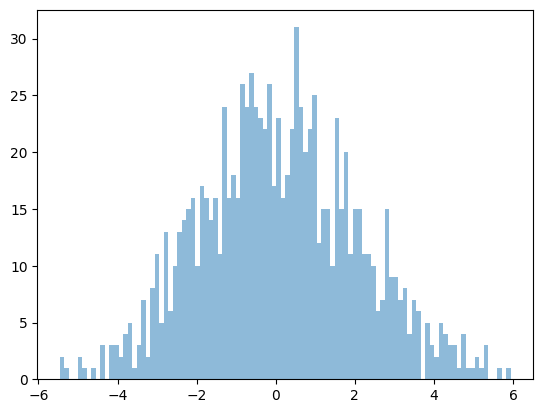

In [81]:
x1 = p1.sample((1000,)).to(device)
# plt.scatter(x1[:,0].cpu(), x1[:,1].cpu(), alpha=0.1)
plt.hist(x1[:,0].cpu(), bins=100, alpha=0.5)
plt.show()

In [107]:
def odefunc(t, x_in):
    x = x_in[..., :-1].clone().detach().requires_grad_(True)
    t = t.to(device)
    vecfield = lambda x: drift(x, t)
    dx, div = output_and_div(vecfield, x)
    div = div.reshape(-1, 1)
    return torch.cat([dx, div], dim=-1)

with torch.no_grad():
    if reverse_time:
        x1 = torch.randn(1024, 2).to(device) * sigma
        time = torch.linspace(1, 0, 1000).to(device)
    else:
        x1 = p1.sample((1000,)).to(device)
        time = torch.linspace(0, 1, 1000).to(device)
    state1 = torch.cat([x1, torch.zeros_like(x1[..., :1])], dim=-1)
    state1.requires_grad = True
    state0 = odeint(odefunc, state1, t=time, method="euler")[-1]

    x0, logdetjac = state0[..., :-1], state0[..., -1]
    p0 = prior_dist(beta)
    logp0 = p0.log_prob(x0)
    logp1 = (logp0 + logdetjac)

In [108]:
print("logp0", logp0.mean())
print("logdetjac", logdetjac.mean())
print("logp1", logp1.mean())

logp0 tensor(-4.8418, device='cuda:0')
logdetjac tensor(2.7684, device='cuda:0')
logp1 tensor(-2.0734, device='cuda:0')


In [109]:
logp0_true = true_Rt(x0, time[-1], beta)
print("logp0_true", logp0_true.mean())
logp1_true = p1.log_prob(x1)
print("logp1_true", logp1_true.mean())

logp0_true tensor(-4.8417, device='cuda:0')
logp1_true tensor(-2.1032, device='cuda:0')


logp1_true tensor(-2.0950, device='cuda:0')


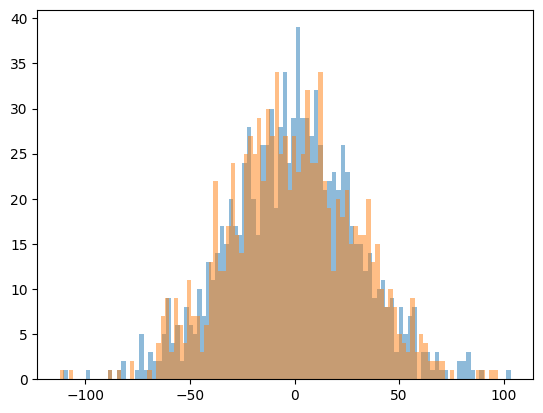

In [84]:
plt.hist(x0[:,0].cpu(), bins=100, alpha=0.5)
prior_samples = p0.sample((1000,)).to(device)
plt.hist(prior_samples[:,0].cpu(), bins=100, alpha=0.5)
plt.show()